# Google Analytics Customer Revenue Prediction

### By Hsuan-Hao Fan

I have loaded project on IBM Watson Studio so the object, called `project`, has the following methods:

In [3]:
dir(project)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_access_token',
 '_check_v2_assets',
 '_fetch_project_context',
 '_get_connection_id_by_name',
 '_get_file_name_from_asset_metadata',
 '_get_project_controller',
 '_project_controller',
 '_project_id',
 '_segmentHandler',
 '_spark_context',
 '_valid_file_name',
 'get_assets',
 'get_connected_data',
 'get_connection',
 'get_connections',
 'get_description',
 'get_file',
 'get_file_url',
 'get_files',
 'get_metadata',
 'get_name',
 'get_project_bucket_name',
 'get_storage_metadata',
 'project_context',
 'save_data']

In [4]:
# Import libraries to use

# Common imports
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
#from preprocess import read_data, json_read

from datetime import datetime # To access datetime

import warnings                # To ignore the warning
warnings.filterwarnings("ignore")

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Auxiliary Functions

In [5]:
import pandas as pd
import numpy as np
import json
import os # it's a operational system library, to set some informations

def read_data(file_path, file_name, data_format):
    """
    Parameters:
    -----------
    file_path: str 
               where the datafile is
    file_name: str
               file name of the datafile
    data_format: dict
                 format of data to import
                 
    Return
    ------
    df: dataframe
        the df after preprocessing
    """
    # Load the data
    df = pd.read_csv(file_path + file_name, dtype = data_format)
    
    # Printing the shape of dataframes that was imported     
    print("Loaded file at {}, and dataframe with shape {}".format(file_path + file_name, df.shape))
    
    return df


def json_read(df, field_name, extract_field, new_field_name):
    """
    Read semi-structured JSON data
    
    Parameters:
    ----------
    df: dataframe
        the dataframe needed to process
    field_name: str
                column to read json data
    extract_field: str 
                   info to extract from json data format
    new_field_name: str
                    add a column for data extract from json data format
                    
    Return
    ------
    df: dataframe
        the df after extracting data from json data format and adding to a new column, called new_field_name
    """
    df[new_field_name] = pd.DataFrame(df[field_name].apply(json.loads).tolist())[[extract_field]]
    return df

# 1. Load Data

Load training set:

In [6]:
df_train = pd.read_csv(project.get_file('train.csv'))
df_train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [7]:
# Check data type in each column
df_train.dtypes

channelGrouping         object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [8]:
df_train.describe()

,date,visitId,visitNumber,visitStartTime
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09


In [9]:
# Check memory usage in MB
df_train.memory_usage(deep=True)* 1e-6

Index                     0.000080
channelGrouping          60.390927
date                      7.229224
device                  715.709069
fullVisitorId            45.430531
geoNetwork              416.747069
sessionId                78.508431
socialEngagementType     69.581281
totals                  113.521380
trafficSource           216.702752
visitId                   7.229224
visitNumber               7.229224
visitStartTime            7.229224
dtype: float64

In [10]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 1.7455084159999998 Gb


## Data Fields

- **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping** - The channel via which the user came to the Store.
- **date** - The date on which the user visited the Store.
- **device** - The specifications for the device used to access the Store.
- **geoNetwork** - This section contains information about the geography of the user.
- **sessionId** - A unique identifier for this visit to the store.
- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals** - This section contains aggregate values across the session.
- **trafficSource** - This section contains information about the Traffic Source from which the session originated.
- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime** - The timestamp (expressed as POSIX time).
- **hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits. (new in version 2 data set)
- **customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set. (new in version 2 data set)


In [6]:
df_test = pd.read_csv(project.get_file('test.csv'), nrows=100)
df_test.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220
3,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""8"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,1,1508193530
4,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""9"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,1,1508217442


In [7]:
del df_test

In [7]:
chunksize = 10000
for chunk in pd.read_csv(project.get_file('test.csv'), chunksize=chunksize):
    df_test_new = chunk
    break

df_test_new.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220
3,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""8"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,1,1508193530
4,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""9"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,1,1508217442


In [8]:
del df_test_new

## What am I predicting?

The following is the sample submission.

In [14]:
df_submit = pd.read_csv(project.get_file('sample_submission.csv'))
df_submit.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [15]:
del df_submit

For each `fullVisitorId` in the test set, we must predict the **natural log** of their total revenue in `PredictedLogRevenue`. The submission file should contain a header and have the following format:

```
fullVisitorId,PredictedLogRevenue
0000000259678714014,0
0000049363351866189,0
0000053049821714864,0
etc.
```

We are predicting the natural log of the **sum of all transactions per user**. For every user in the test set, the target is:

$$ y_{user}=\sum_{i=1}^{n}transaction_{user_i}$$

$$ target_{user}=\ln(y_{user}+1)$$

where $n$ is the number of times a specific customer vistied the GStore. 

**Why do we choose above metric to gauage the performance?**

Since each transaction is a large value, if we use those values directly, then it will not be sensitive to the minor changes! Thus, we  apply natural log to $y_{user}$. The reason why we consider $y_{user}+1$ is because some users may not purchase anything and $y_{user}=0$. Then $\ln (y_{user})$ will not be well-defined! In contrast, $\ln (y_{user}+1) = 0$ when $y_{user} = 0$. 

Note that Kaggle has updated dataset, `train_v2.csv` and `test_v2.csv`, and the training dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.

In [11]:
df_train.loc[0,'geoNetwork']

'{"continent": "Asia", "subContinent": "Western Asia", "country": "Turkey", "region": "Izmir", "metro": "(not set)", "city": "Izmir", "cityId": "not available in demo dataset", "networkDomain": "ttnet.com.tr", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [12]:
df_train.loc[10,'device']

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Android", "operatingSystemVersion": "not available in demo dataset", "isMobile": true, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "tablet"}'

In [13]:
df_train.loc[1,'device']

'{"browser": "Firefox", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Macintosh", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [14]:
df_train.loc[21,'device']

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Android", "operatingSystemVersion": "not available in demo dataset", "isMobile": true, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "mobile"}'

Note that `deviceCategory` and `isMobile` are related actually. If `deviceCategory` is mobile or tablet, then `isMobile` is true. If `deviceCategory` is desktop, then `isMobile` is false. We will examine these two features later to see whether it's necessary to consider `deviceCategory` or not.

In [15]:
df_train.loc[101,'device']

'{"browser": "Safari", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "iOS", "operatingSystemVersion": "not available in demo dataset", "isMobile": true, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "mobile"}'

In [16]:
df_train.loc[80,'totals']

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

In [17]:
df_train.loc[102,'trafficSource']

'{"campaign": "AW - Dynamic Search Ads Whole Site", "source": "google", "medium": "cpc", "keyword": "6qEhsCssdK0z36ri", "adwordsClickInfo": {"page": "1", "slot": "Top", "criteriaParameters": "not available in demo dataset", "gclId": "Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFawcmsrhs02pjO7FXPLhzHyvJFv53h1H4QJ8aAhtw8P8HAQ", "adNetworkType": "Google Search", "isVideoAd": false}}'

In **device, geoNetwork, totals, trafficSource** fields, they are semi-structured JSON data.

- **device**: **browser**, browserVersion, browserSize, operatingSystem, operatingSystemVersion, **isMobile**, mobileDeviceBranding, mobileDeviceModel, mobileInputSelector, mobileDeviceInfo, mobileDeviceMarketingName, flashVersion, language, screenColors, screenResolution, deviceCategory
- **totals**: visits, hits, pageviews, newVisits, bounces
- **geoNetwork**: continent, subContinent, country, region, metro, city, cityId, networkDomain, latitude, longitude, networkLocation
- **trafficSource**: campaign, source, medium, keyword, adwordsClickInfo, referralPath


In [18]:
# Extract revenue from transactionRevenue from totals field
field_name = 'totals' 
extract_field = 'transactionRevenue'
new_field_name = 'revenue'

json_read(df_train, field_name, extract_field, new_field_name).head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385,NaN
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147,NaN
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386,NaN
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213,NaN
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600,NaN


In [19]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 1.774808064 Gb


In [20]:
# Check missing values in revenue field
df_train['revenue'].isnull().sum()

892138

There are 892138 missing values out of 903653. That means that **we only have 11515 non-missing values in `revenue` field**. This is highly **unbalanced dataset**. We have to keep this in mind when we build model to do further analysis. We denote these missing values by 0 since they may be events that customers visit gstore without purchasing any products.

In [21]:
# Fill in missing data with zeros
df_train['revenue'] = df_train['revenue'].fillna(0)
df_train.head(7)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385,0
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147,0
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386,0
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213,0
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600,0
5,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2938943183656635653,"{""continent"": ""Europe"", ""subContinent"": ""South...",2938943183656635653_1472807194,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472807194,1,1472807194,0
6,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1905672039242460897,"{""continent"": ""Asia"", ""subContinent"": ""Souther...",1905672039242460897_1472817241,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472817241,1,1472817241,0


In [22]:
df_train['revenue'] = df_train['revenue'].astype('int64')
df_train.dtypes

channelGrouping         object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
sessionId               object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
revenue                  int64
dtype: object

In order to determine what factors affect whether customers purchase things or not when they visit gstore, we set 0 when revenue is 0 (not purchasing) and 1 when revenue is not 0 (purchasing) as shown in column `Buy`.

In [23]:
df_train['Buy'] = df_train['revenue'].apply(lambda x: 1 if x != 0 else 0)
df_train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue,Buy
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385,0,0
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147,0,0
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386,0,0
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213,0,0
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600,0,0


In [24]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 1.759966864 Gb


# 2. Data Explore, Clean Data and Feature Engineering

## 2.1 channelGrouping feature

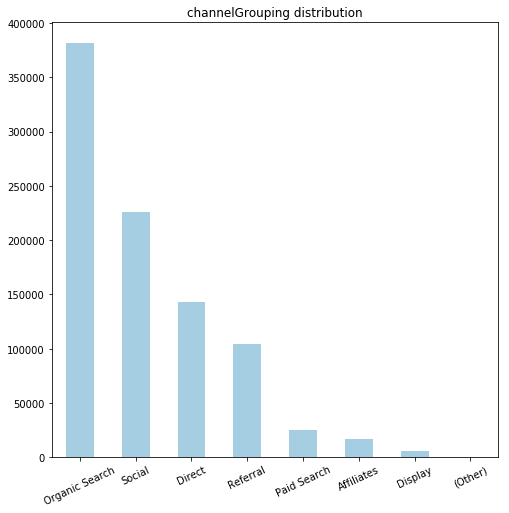

In [25]:
df_train.channelGrouping.value_counts().plot(kind="bar",title="channelGrouping distribution",figsize=(8,8),rot=25,colormap='Paired')

From above figure, we can see that most of customers used `Organic Search` channel to come to gstore, and `Social` channel is the second one. But does it mean there are more customers purchasing goods in gstore from `Organic Search` channel? Let's find out below.

### channelGrouping vs. revenue

In [26]:
df_channel = df_train[['channelGrouping','revenue', 'Buy']]
(df_channel.set_index('channelGrouping').groupby(level=0)['revenue'].agg({'mean': np.average, 'median':np.median, 'std':np.std, 
                                                                          'max': np.max, 'min': np.min}) )

,max,std,min,mean,median
channelGrouping,,,,,
(Other),9990000,9.119581e+05,0,8.325000e+04,0
Affiliates,233850000,2.594414e+06,0,3.641895e+04,0
Direct,17855500000,8.642141e+07,0,3.040290e+06,0
Display,23129500000,3.437883e+08,0,1.250997e+07,0
Organic Search,6248750000,2.340972e+07,0,8.553823e+05,0
Paid Search,1523180000,2.575310e+07,0,1.719928e+06,0
Referral,8248800000,6.756077e+07,0,6.213681e+06,0
Social,227980000,1.322326e+06,0,2.174335e+04,0


According to mean and median of revenue for each channelGrouping, it is clear that in each channelGrouping, there are many customers visiting gstore without purchasing! **The distribution of data in each channel is highly left-skewed**.

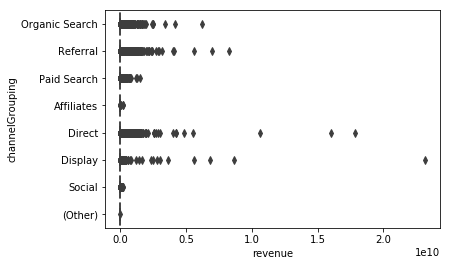

In [27]:
# Visualize the data by drawing boxplot grouped by a categorical variable:
sns.boxplot(x='revenue', y='channelGrouping', data=df_channel)

In order to study the relation between channelGrouping and revenue, we'd better to study `revenue = 0` and `revenue != 0` separately, or data with `revenue=0` will worse the model prediction later. **Therefore, we can classify whether customers buy goods or not when they visit gstore. For those who don't buy goods in gstore, of course the revecue those customers contribute is 0. In contrast, for those who purchase goods, we predict the revenue each customer contribute by using linear regression model.**

### Are those customers used specific channel most possible to buy goods in gstore?

In [28]:
Channel_Buy = (df_channel.groupby(['channelGrouping', 'Buy'])['revenue'].agg({'Count':'count'}))
Channel_Buy['Relative Frequency'] = Channel_Buy.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
Channel_Buy

Count  Relative Frequency
channelGrouping Buy                            
(Other)         0       119           99.166667
                1         1            0.833333
Affiliates      0     16394           99.945132
                1         9            0.054868
Direct          0    140984           98.572288
                1      2042            1.427712
Display         0      6120           97.732354
                1       142            2.267646
Organic Search  0    378123           99.098965
                1      3438            0.901035
Paid Search     0     24858           98.152097
                1       468            1.847903
Referral        0     99527           94.934089
                1      5311            5.065911
Social          0    226013           99.954006
                1       104            0.045994

From above results, we can conclude that **customers from Referral channel are most possible to buy goods in gstore per visit**. Hence, when we build classification model, we may take `channelGrouping` feature into account.

### Did customers who purchased goods in gstore from specific channel buy more?

In order to answer this question, we show boxplot for categorical variable (channelGrouping) vs. numerical variable (revenue).

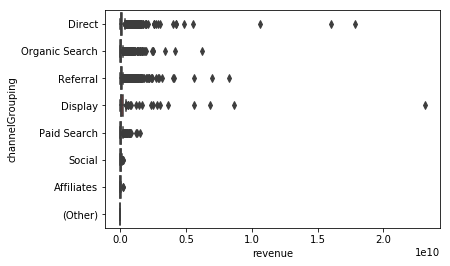

In [29]:
# boxplot for categorical variable (channelGrouping) vs. numerical variable (revenue)
df_channel_Buy = df_channel[df_channel['Buy'] == 1]
sns.boxplot(x='revenue', y='channelGrouping', data=df_channel_Buy)

From above figure, we cannot see the relation between channelGrouping and revenue due to large range of revenue in each channel. Thus, we do log transformation for revenue in the following.

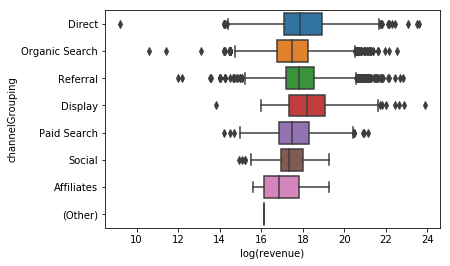

In [30]:
# Transform revenue by log function
df_channel_Buy['log(revenue)'] = df_channel_Buy['revenue'].apply(np.log)
sns.boxplot(x='log(revenue)', y='channelGrouping', data=df_channel_Buy)

From above figure, we can see that **`revenue` has very weak relationship with `channelGrouping`** since median in each channel is close to each other. Hence, we may not include `channelGrouping` into our model to predict revenue.

In [31]:
# Delete useless dataframe
del df_channel_Buy, Channel_Buy, df_channel

## 2.2 date feature

There are two variables related to time and can be used in time dependent analyzes, or Time Series. Now we study the relation between date feature and counts of customers purchasing.


**1) Hypothesis Generation**

a. There will be more customers purchasing goods during the holiday season, say Nov. and Dec.
- Explanation - Purchasing rate will be higher during the holiday season.

b. There will be more customers purchasing goods during the weekend.
- Explanation - People need to work on weekdays so they may not have time to visit GStore.

c. There will be higher transaction per visit during the holiday season, say Nov. and Dec.
- Explanation - People will buy more goods when Thanksgiving, Christmas, and New Year coming.

**2) Feature Extraction**

We will extract further info from the `date`. We have seen earlier that the data type of `date` is int64. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [32]:
df_train['date'] = pd.to_datetime(df_train['date'],format="%Y%m%d") 

In [33]:
df_train.head()['date']

0   2016-09-02
1   2016-09-02
2   2016-09-02
3   2016-09-02
4   2016-09-02
Name: date, dtype: datetime64[ns]

 Let's extract the year, month, day from the `date` to validate our hypothesis.

In [34]:
df_time = df_train[['date', 'revenue', 'Buy']]
df_time['year'] = pd.DatetimeIndex(df_time['date']).year
df_time['month'] = pd.DatetimeIndex(df_time['date']).month
df_time['day'] = pd.DatetimeIndex(df_time['date']).day

In [35]:
df_time.head()

,date,revenue,Buy,year,month,day
0,2016-09-02,0,0,2016,9,2
1,2016-09-02,0,0,2016,9,2
2,2016-09-02,0,0,2016,9,2
3,2016-09-02,0,0,2016,9,2
4,2016-09-02,0,0,2016,9,2


We made a hypothesis that customers will purchase more goods on weekday and weekend as well. So, let's make a weekend variable to visualize the impact of weekend on purchasing rate.

 - We will first extract the day of week from `date` and then based on the values we will assign whether the day is a weekend or not.

 - Values of 5 and 6 represents that the days are weekend.



In [36]:
df_time['DayOfWeek']=df_time['date'].dt.dayofweek
temp = df_time['date']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [37]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = df_time['date'].apply(applyer)
df_time['weekend']=temp2

Let's look at the time series.

In [38]:
df_time.index = df_time['date'] # indexing the Datetime to get the time period on the x-axis.
df_time.head()

,date,revenue,Buy,year,month,day,DayOfWeek,weekend
date,,,,,,,,
2016-09-02,2016-09-02,0,0,2016,9,2,4,0
2016-09-02,2016-09-02,0,0,2016,9,2,4,0
2016-09-02,2016-09-02,0,0,2016,9,2,4,0
2016-09-02,2016-09-02,0,0,2016,9,2,4,0
2016-09-02,2016-09-02,0,0,2016,9,2,4,0


In [39]:
df_time_buy = df_time[df_time['Buy'] == 1]
df_time_buy.head()

,date,revenue,Buy,year,month,day,DayOfWeek,weekend
date,,,,,,,,
2016-09-02,2016-09-02,37860000,1,2016,9,2,4,0
2016-09-02,2016-09-02,306670000,1,2016,9,2,4,0
2016-09-02,2016-09-02,68030000,1,2016,9,2,4,0
2016-09-02,2016-09-02,26250000,1,2016,9,2,4,0
2016-09-02,2016-09-02,574150000,1,2016,9,2,4,0


**3) Exploratory Analysis**

Our first hypothesis was purchasing rate will be higher in holiday season.

Text(0,0.5,'Visit Count')

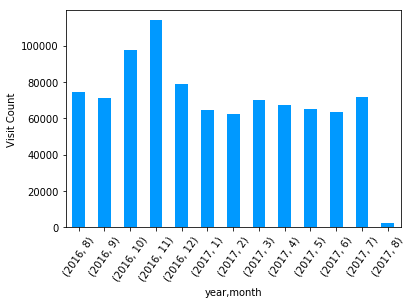

In [40]:
# using an html hex string for color
color = '#0099ff'
df_time.groupby(['year','month']).size().plot.bar(rot = 55, color=color)
plt.ylabel('Visit Count')

As we can see in above figure, **there are more customers visiting GStore in Oct., Nov., and Dec. due to holiday season**. In particular, there are the most customers visiting GStore in Nov. It is reasonable since people normally look for gifts before Christmas, and there may more deductions in Nov. like Black Friday. But does it also implies higher purchasing rate in that period? Let's examine that in the following.

Text(0,0.5,'Purchasing Rate')

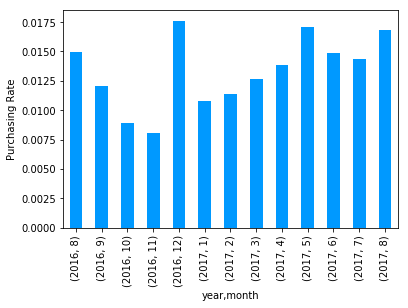

In [41]:
df_time.groupby(['year','month'])['Buy'].mean().plot.bar(color=color)
plt.ylabel('Purchasing Rate')

As we can see in above figure, **there's no clear relation between time and purchasing rate so we won't include the month to determine whether customers will buy goods in GStore or not**.

Next, we examine our second hypothesis, there will be more customers purchasing goods during the weekend.

Text(0,0.5,'Purchasing Rate')

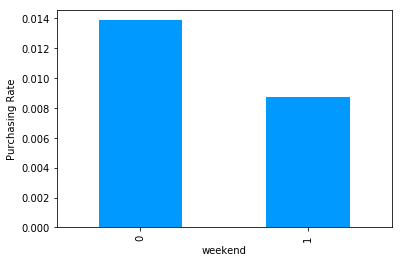

In [42]:
df_time.groupby('weekend')['Buy'].mean().plot.bar(color=color)
plt.ylabel('Purchasing Rate')

In above figure, 0 denotes the weekday and 1 denotes the weekend. It is clear that our second hypothesis is not right. From the figure, we can see that **there are higher purchasing rate in weekdays**. Probably, that is because when people work or people go to office on weekdays, they have more chances to access the electric devices to visit the Google Merchandise Store.

In the end, we examine whether there will be higher transaction per visit during the holiday season, say Nov. and Dec. in the following:

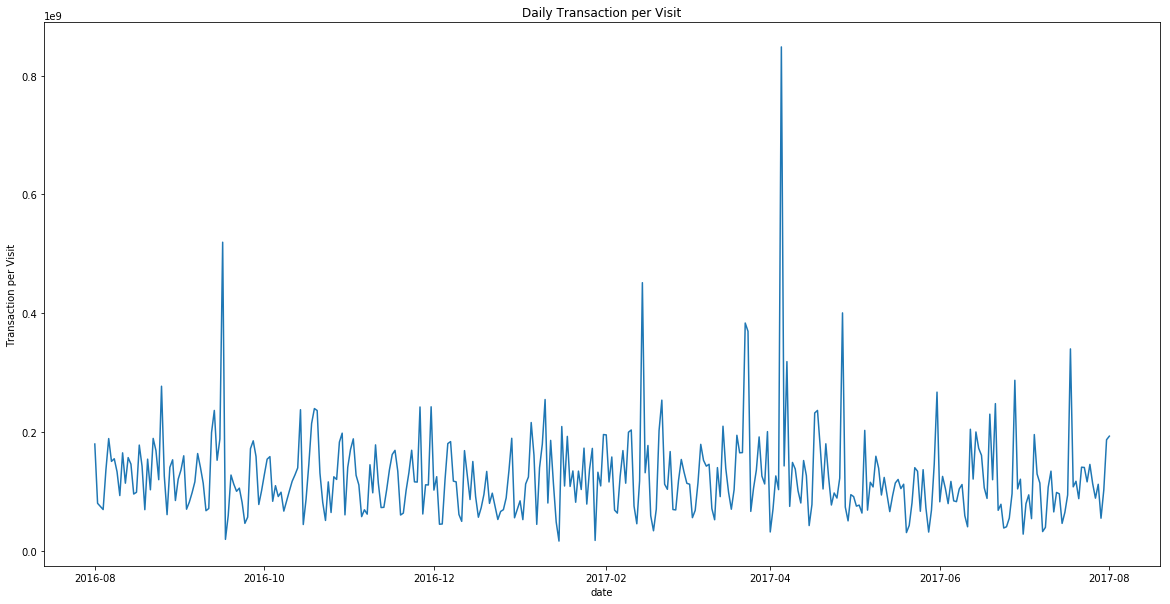

In [43]:
daily_transaction_per_visit_df = df_time_buy[['date','revenue']].groupby(by=['date'],axis=0).mean()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Daily Transaction per Visit")
axes.set_ylabel("Transaction per Visit")
axes.set_xlabel("date")
axes.plot(daily_transaction_per_visit_df["revenue"])

From above result, we can see that the transaction per visit do not peak at Nov. and Dec. so our last hypothesis is wrong. **Note that since we will predict the transaction per visit if customer buy goods in the store, we will classify whether customer will purchase or not per visit first. Then predict the transaction value per visit for those who will purchase products in the store so we DO NOT include the transaction  value per visit, or 0, for those who will not purchase into model training.** As we have seen earlier, there are many zero transaction value per visit in the training dataset so if we include them into modle construction, then they will worse the accuracy of prediction. 

In [44]:
# Clean dataframe
del daily_transaction_per_visit_df, df_time_buy, df_time

## 2.3 device feature

The field, `device`, is stored in json format. It is necessary to extract its fields and analyze them. Using `json_read` function to deserializing json values.

In [45]:
df_train.iloc[10,2]

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Android", "operatingSystemVersion": "not available in demo dataset", "isMobile": true, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "tablet"}'

There are many keys in device attribute with values "not available in demo dataset" so we should ignore these features. 

### What device do customers frequently use to visit the store?

In order to answer this question, we consider `deviceCategory` in the following. Note that `isMobile` and `deviceCategory` are related. In what follows, we also examine whther using `deviceCategory` can gain more insight, or one can use `isMobile` instead.

In [46]:
df_device = df_train[['device', 'revenue', 'Buy']]

In [47]:
# Extract deviceCategory from device field
field_name = 'device' 
extract_field = 'deviceCategory'
new_field_name = 'DeviceCategory'

json_read(df_device, field_name, extract_field, new_field_name).head()

,device,revenue,Buy,DeviceCategory
0,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop
1,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",0,0,desktop
2,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop
3,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",0,0,desktop
4,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,mobile


In [48]:
# Check whether there's missing values in DeviceCategory column
pd.isna(df_device['DeviceCategory']).sum()

0

Text(0,0.5,'Visit Count')

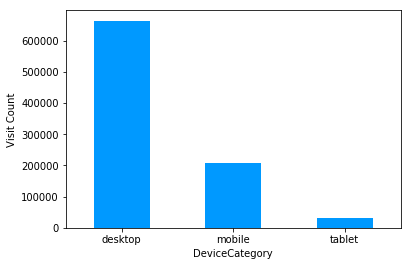

In [49]:
# using an html hex string for color
color = '#0099ff'
df_device.groupby(['DeviceCategory']).size().plot.bar(rot = 0, color=color)
plt.ylabel('Visit Count')

As we can see in the above bar plot, **most of customers visit the store via desktop device**. Also, visit counts for tablet is very small compared to mobile and desktop, and tablet and mobile can be regarded as mobile devices. Hence, we can group mobile and tablet features together, and we can classify the device is mobile device or not. This is nothing but `isMobile` in `device` attribute. Let's extract `isMobile` from `device` in the following:

In [50]:
# Extract deviceCategory from device field
field_name = 'device' 
extract_field = 'isMobile'
new_field_name = 'IsMobile'

json_read(df_device, field_name, extract_field, new_field_name).head()

,device,revenue,Buy,DeviceCategory,IsMobile
0,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop,False
1,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",0,0,desktop,False
2,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop,False
3,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",0,0,desktop,False
4,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,mobile,True


From above table, we can see that `IsMobile` is False if  `DeviceCategory` is "desktop". In contrast, `IsMobile` is True if  `DeviceCategory` is "mobile" or "tablet".

In [51]:
# Estimate total memory usage
usage = df_device.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 0.7886659559999999 Gb


In [52]:
# Check data type in IsMobile
df_device['IsMobile'].dtypes

dtype('bool')

### Is IsMobile related to purchasing rate?

Text(0,0.5,'Purchasing Rate')

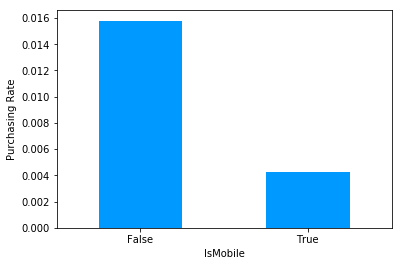

In [53]:
df_device.groupby('IsMobile')['Buy'].mean().plot.bar(color=color, rot = 0)
plt.ylabel('Purchasing Rate')

From above result, we can see that customers using desktop are more willing to purchase in store. Thus, **when we build classifier to determine whether customer will purchase or not when visiting the store, we need to include `IsMobile` feature.** 

### Is IsMobile related to revenue per visit?

In [54]:
df_device_Buy = df_device[df_device['Buy']==1]
df_device_Buy.head()

,device,revenue,Buy,DeviceCategory,IsMobile
752,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",37860000,1,desktop,False
753,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",306670000,1,desktop,False
799,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",68030000,1,desktop,False
802,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",26250000,1,desktop,False
859,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",574150000,1,desktop,False


In [55]:
# Transform revenue by log function
df_device_Buy['log(revenue)'] = df_device_Buy['revenue'].apply(np.log)

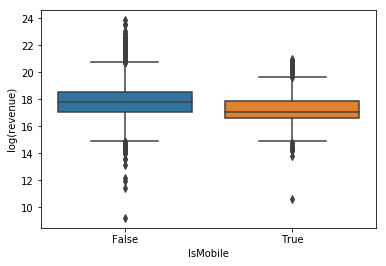

In [56]:
sns.boxplot(x='IsMobile', y='log(revenue)', data=df_device_Buy)

As we can see in the above box plot, the medians for mobile device and non-mobile device are very close to each other. This implies that revenue per visit is not correlated to `IsMobile` feature. Thus, **we won't include `IsMobile` feature into our model to predict revenue per visit.**

In [57]:
del df_device_Buy, df_device

## 2.4 geoNetwork

The field, `geoNetwork`, is stored in json format. It is necessary to extract its fields and analyze them. Using json_read function to deserializing json values.

In [58]:
df_train.loc[21,'geoNetwork']

'{"continent": "Europe", "subContinent": "Western Europe", "country": "Germany", "region": "(not set)", "metro": "(not set)", "city": "(not set)", "cityId": "not available in demo dataset", "networkDomain": "live-servers.net", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [59]:
df_geo = df_train[['geoNetwork', 'revenue', 'Buy']]
df_geo.head()

,geoNetwork,revenue,Buy
0,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0
1,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",0,0
2,"{""continent"": ""Europe"", ""subContinent"": ""South...",0,0
3,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",0,0
4,"{""continent"": ""Europe"", ""subContinent"": ""North...",0,0


In [60]:
# Estimate total memory usage
usage = df_geo.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 0.43120559699999994 Gb


### Which continent has the most visitors to GStore?

In [61]:
# Extract continent from geoNetwork field
field_name = 'geoNetwork' 
extract_field = 'continent'
new_field_name = 'continent'

json_read(df_geo, field_name, extract_field, new_field_name).head()

,geoNetwork,revenue,Buy,continent
0,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0,Asia
1,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",0,0,Oceania
2,"{""continent"": ""Europe"", ""subContinent"": ""South...",0,0,Europe
3,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",0,0,Asia
4,"{""continent"": ""Europe"", ""subContinent"": ""North...",0,0,Europe


Text(0,0.5,'visit counts')

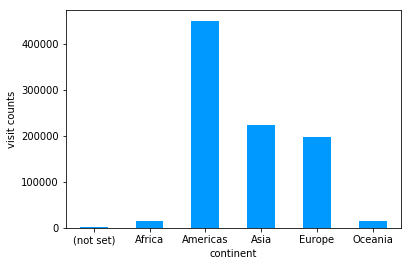

In [62]:
df_geo.groupby('continent').size().plot.bar(color=color, rot = 0)
plt.ylabel('visit counts')

From above bar plot, we can see that most of customers are from Americas. Then the second most is from Asia. And visit counts from Europe is close to Asia. Hence, we can conclude that most of customers are from these three continents, Americas, Asia, and Europe.

### Which continent has the highest purchasing rate?

Text(0,0.5,'Purchasing Rate')

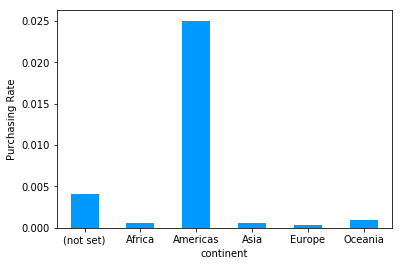

In [63]:
df_geo.groupby('continent')['Buy'].mean().plot.bar(color=color, rot = 0)
plt.ylabel('Purchasing Rate')

From above bar plot, we can see that the highest purchasing rate is in Americas. **This impliest that customers from Americas have higher possibility to buy things in GStore.** Thus, we can include this feature in our classifier.

In [64]:
# Extract country from geoNetwork field
field_name = 'geoNetwork' 
extract_field = 'country'
new_field_name = 'country'

json_read(df_geo, field_name, extract_field, new_field_name).head()

,geoNetwork,revenue,Buy,continent,country
0,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0,Asia,Turkey
1,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",0,0,Oceania,Australia
2,"{""continent"": ""Europe"", ""subContinent"": ""South...",0,0,Europe,Spain
3,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",0,0,Asia,Indonesia
4,"{""continent"": ""Europe"", ""subContinent"": ""North...",0,0,Europe,United Kingdom


### Which country in Americas has the highest purchasing rate?

In [65]:
df_americas = df_geo[df_geo['continent'] == 'Americas'] 
df_americas.groupby('country')['Buy'].mean().sort_values(ascending=False).head(10)

country
Anguilla         1.000000
St. Lucia        0.083333
Guadeloupe       0.034483
Curaçao          0.033333
United States    0.030029
Venezuela        0.029550
Puerto Rico      0.015027
Canada           0.007345
Nicaragua        0.007194
Panama           0.004202
Name: Buy, dtype: float64

Visitors from Anguilla in Americas are the most probable to purchase goods in Gstore. But is it reasonable? Let's take a look at how many visits are from Anguilla below.

In [66]:
# How many visitors are from Anguilla?
len(df_americas[df_americas['country']=='Anguilla'])

1

It is clear that we do not have enough data from this country so we cannot conclude that visitors from Anguilla in Americas are the most probable to purchase goods in Gstore. Let's examine other countries, St. Lucia, Guadeloupe, Curaçao, and United States, with high purchasing rate in the following:

In [67]:
df_americas.groupby('country').size().sort_values(ascending=False).head(25)

country
United States         364744
Canada                 25869
Brazil                 19783
Mexico                 13225
Peru                    5546
Argentina               5037
Colombia                4880
Venezuela               2132
Chile                   1950
Ecuador                 1251
Dominican Republic       934
Puerto Rico              732
Uruguay                  627
Guatemala                581
Costa Rica               554
Panama                   476
El Salvador              393
Bolivia                  318
Honduras                 188
Trinidad & Tobago        164
Jamaica                  153
Nicaragua                139
Paraguay                 132
Martinique                61
Barbados                  55
dtype: int64

As we can see in above results, there are less than 55 visits in St. Lucia, Guadeloupe, Curaçao so we cannot conclude whether customers from these countries are more willing to buy in GStore. In contrast, **United States has the highest visits and higher purchasing rate.** This is an important feature we can consider!

### Is continent related to revenue?

In [68]:
df_geo_Buy = df_geo[df_geo['Buy']==1]
df_geo_Buy.head()

,geoNetwork,revenue,Buy,continent,country
752,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",37860000,1,Americas,United States
753,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",306670000,1,Americas,United States
799,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",68030000,1,Americas,United States
802,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",26250000,1,Americas,United States
859,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",574150000,1,Americas,United States


In [69]:
# Transform revenue by log function
df_geo_Buy['log(revenue)'] = df_geo_Buy['revenue'].apply(np.log)

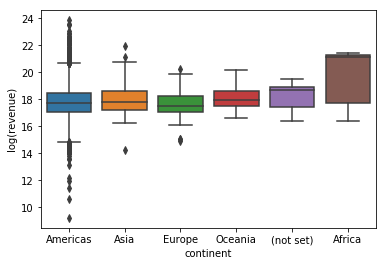

In [70]:
sns.boxplot(x='continent', y='log(revenue)', data=df_geo_Buy)

As we can see in above box plot, the median of `log(revenue)` for each continent is close, except for Africa. But the distribution of `log(revenue)` for Africa is highly right-skewed. Let's take a look at how many visits with purchasing in Africa in the following:

In [71]:
len(df_geo_Buy[df_geo_Buy['continent']== 'Africa'])

8

The samples in Africa are very less so the results cannot really show that customers from Africa contribute higher revenues compared with customers from other continents. Therefore, when we predict revenues, we will not include `continent` feature.

In [72]:
del df_americas, df_geo, df_geo_Buy

## 2.5 social Engagement Type

In this section, we study the relation between purchasing rate and `socialEngagementType`. Then we study whether `revenue` is related to `socialEngagementType`.

### Which social Engagement Type has more visits?

Text(0,0.5,'Visits')

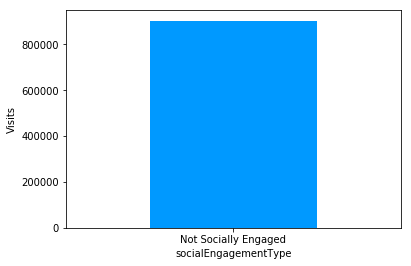

In [73]:
# using an html hex string for color
color = '#0099ff'
df_train.groupby(['socialEngagementType']).size().plot.bar(rot = 0, color=color)
plt.ylabel('Visits')

In [74]:
df_train['socialEngagementType'].count()

903653

In this feature, samples in training set are all in the same category so it is not useful to include this feature into our model.

## 2.6 Traffic Source

In [75]:
df_train.loc[101,'trafficSource']

'{"referralPath": "/od/Things-To-Do-in-Silicon-Valley/fl/How-To-Visit-the-Googleplex-the-Google-Head-Office-in-Mountain-View.htm", "campaign": "(not set)", "source": "siliconvalley.about.com", "medium": "referral", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [76]:
df_train.loc[102,'trafficSource']

'{"campaign": "AW - Dynamic Search Ads Whole Site", "source": "google", "medium": "cpc", "keyword": "6qEhsCssdK0z36ri", "adwordsClickInfo": {"page": "1", "slot": "Top", "criteriaParameters": "not available in demo dataset", "gclId": "Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFawcmsrhs02pjO7FXPLhzHyvJFv53h1H4QJ8aAhtw8P8HAQ", "adNetworkType": "Google Search", "isVideoAd": false}}'

In [77]:
df_train.loc[103,'trafficSource']

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In above three instances, except for those not available info, the most useful feature is `medium` but it's already extracted in `channelGrouping`.

## 2.7 totals

Except for `transactionRevenue`, there are other useful features stored in json format in `totals` field like `visits`, `hits`, and `pageviews`.

In [78]:
df_train.loc[80,'totals']

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

In [79]:
df_train.loc[1001,'totals']

'{"visits": "1", "hits": "34", "pageviews": "23", "newVisits": "1"}'

In [80]:
df_train.loc[302,'totals']

'{"visits": "1", "hits": "2", "pageviews": "2", "newVisits": "1"}'

In [81]:
df_totals = df_train[['totals', 'revenue', 'Buy']]
df_totals.head()

,totals,revenue,Buy
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
1,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
2,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
3,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
4,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0


In [82]:
# View momory usage including objects
df_totals.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 3 columns):
totals     903653 non-null object
revenue    903653 non-null int64
Buy        903653 non-null int64
dtypes: int64(2), object(1)
memory usage: 122.1 MB


### visits feature in totals

In [83]:
# Extract visits from totals field
field_name = 'totals' 
extract_field = 'visits'
new_field_name = 'visits'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,visits
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
1,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
2,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
3,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
4,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1


In [84]:
df_totals.groupby('visits').size()

visits
1    903653
dtype: int64

From above result, the values in visits attribute are all 1 so this feature cannot offer any insight we need. But **it implies that in this data set, each instance is related to distinct customer visiting GStore**. 

In [85]:
# Drop unuseful feature to release memory
df_totals.drop(columns='visits', inplace=True)
df_totals.head()

,totals,revenue,Buy
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
1,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
2,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
3,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
4,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0


### hits and pageviews features in totals

In [86]:
# Extract hits from totals field
field_name = 'totals' 
extract_field = 'hits'
new_field_name = 'hits'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,hits
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
1,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
2,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
3,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
4,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1


In [87]:
df_totals.groupby('hits').size().head()

hits
1      446754
10      10640
100        39
101        35
102        27
dtype: int64

In [91]:
# Extract pageviews from totals field
field_name = 'totals' 
extract_field = 'pageviews'
new_field_name = 'pageviews'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,hits,pageviews
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1
1,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1
2,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1
3,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1
4,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1


In [93]:
# Check whether there are missing values
df_totals['pageviews'].isna().sum()

100

There are 100 missing values.

In [98]:
df_totals['pageviews'].fillna(value=0, inplace=True)

In [99]:
df_totals.groupby('pageviews').size().head()

pageviews
0         100
1      452522
10      10104
100         9
101         9
dtype: int64

In [101]:
# Take a look at those samples with pageviews=0
df_totals[df_totals['pageviews']==0].tail(10)

,totals,revenue,Buy,hits,pageviews
837579,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
837584,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
837592,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
839268,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
853896,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
855111,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
856964,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
882173,"{""visits"": ""1"", ""hits"": ""2""}",0,0,2,0
884133,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0
888421,"{""visits"": ""1"", ""hits"": ""1""}",0,0,1,0


In [102]:
# Check data types for values in each column
df_totals.dtypes

totals       object
revenue       int64
Buy           int64
hits         object
pageviews    object
dtype: object

In [103]:
# Convert desired columns to numeric type
df_totals[['hits', 'pageviews']] = df_totals[['hits', 'pageviews']].apply(pd.to_numeric) 
df_totals.dtypes

totals       object
revenue       int64
Buy           int64
hits          int64
pageviews     int64
dtype: object

### Take a look at correlations between revenue, Buy, hits, and pageviews

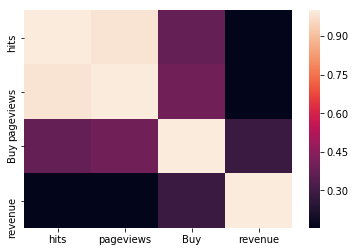

In [104]:
temp_df = df_totals[['hits','pageviews', 'Buy','revenue']]

# Calculate correlations
corr = temp_df.corr()

# Heatmap
sns.heatmap(corr)

From above heatmap, we can see that `hits` and `pageviews` have very weak relation to `revenue`.  **Thus, we can include `hits` and `pageviews` features in our classifier.**

In [105]:
# Delete temporary dataframe
del temp_df, df_totals

# 3. Prepare training data 

According to the data exploration in previous section, we now prepare training data by including only necessary features for model training.

In [6]:
df_train = pd.read_csv(project.get_file('train.csv'))
df_train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [7]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
channelGrouping         903653 non-null object
date                    903653 non-null int64
device                  903653 non-null object
fullVisitorId           903653 non-null object
geoNetwork              903653 non-null object
sessionId               903653 non-null object
socialEngagementType    903653 non-null object
totals                  903653 non-null object
trafficSource           903653 non-null object
visitId                 903653 non-null int64
visitNumber             903653 non-null int64
visitStartTime          903653 non-null int64
dtypes: int64(4), object(8)
memory usage: 1.6 GB


In [8]:
# Drop unused features
unused = ['sessionId', 'socialEngagementType', 'trafficSource', 'visitId', 'visitNumber', 'visitStartTime']
df_train.drop(columns=unused, inplace=True)
df_train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,totals
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",..."
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",..."
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",..."
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",..."
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",..."


In [9]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 6 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
geoNetwork         903653 non-null object
totals             903653 non-null object
dtypes: int64(1), object(5)
memory usage: 1.3 GB


In [10]:
# Extract continent from geoNetwork field
json_read(df_train, field_name='geoNetwork' , extract_field='continent', new_field_name='continent').head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,totals,continent
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe


In [11]:
# Extract country from geoNetwork field
json_read(df_train, field_name='geoNetwork' , extract_field='country', new_field_name='country').head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,totals,continent,country
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...","{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom


In [12]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 8 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
geoNetwork         903653 non-null object
totals             903653 non-null object
continent          903653 non-null object
country            903653 non-null object
dtypes: int64(1), object(7)
memory usage: 1.4 GB


In [13]:
# After extracting necessary features from geoNtework, we drop this attribute
df_train.drop(columns='geoNetwork', inplace=True)

In [14]:
df_train.head()

,channelGrouping,date,device,fullVisitorId,totals,continent,country
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom


In [15]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 7 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
totals             903653 non-null object
continent          903653 non-null object
country            903653 non-null object
dtypes: int64(1), object(6)
memory usage: 1010.9 MB


In [16]:
# Extract hits from totals field
json_read(df_train, field_name='totals' , extract_field='hits', new_field_name='hits').head()

,channelGrouping,date,device,fullVisitorId,totals,continent,country,hits
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey,1
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia,1
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain,1
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia,1
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom,1


In [17]:
# Extract pageviews from totals field
json_read(df_train, field_name='totals' , extract_field='pageviews', new_field_name='pageviews').head()

,channelGrouping,date,device,fullVisitorId,totals,continent,country,hits,pageviews
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey,1,1
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia,1,1
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain,1,1
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia,1,1
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom,1,1


In [18]:
df_train['pageviews'].fillna(value=0, inplace=True)

In [19]:
# Convert desired columns to numeric type
df_train[['hits', 'pageviews']] = df_train[['hits', 'pageviews']].apply(pd.to_numeric) 

In [20]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 9 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
totals             903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
dtypes: int64(3), object(6)
memory usage: 1.0 GB


In [21]:
# Extract revenue from transactionRevenue from totals field
json_read(df_train, field_name='totals' , extract_field='transactionRevenue', new_field_name='revenue').head()

,channelGrouping,date,device,fullVisitorId,totals,continent,country,hits,pageviews,revenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey,1,1,NaN
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia,1,1,NaN
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain,1,1,NaN
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia,1,1,NaN
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom,1,1,NaN


In [22]:
# Fill in missing data with zeros
df_train['revenue'] = df_train['revenue'].fillna(0)
df_train.head(7)

,channelGrouping,date,device,fullVisitorId,totals,continent,country,hits,pageviews,revenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Turkey,1,1,0
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Oceania,Australia,1,1,0
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Spain,1,1,0
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Indonesia,1,1,0
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,United Kingdom,1,1,0
5,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2938943183656635653,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Europe,Italy,1,1,0
6,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1905672039242460897,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",Asia,Pakistan,1,1,0


In [23]:
df_train['revenue'] = df_train['revenue'].astype('int64')
df_train.dtypes

channelGrouping    object
date                int64
device             object
fullVisitorId      object
totals             object
continent          object
country            object
hits                int64
pageviews           int64
revenue             int64
dtype: object

In [24]:
# After extracting necessary features from totals, we drop this attribute
df_train.drop(columns='totals', inplace=True)

In [25]:
df_train.head()

,channelGrouping,date,device,fullVisitorId,continent,country,hits,pageviews,revenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,Asia,Turkey,1,1,0
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,Oceania,Australia,1,1,0
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,Europe,Spain,1,1,0
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,Asia,Indonesia,1,1,0
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,Europe,United Kingdom,1,1,0


In [26]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 9 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
revenue            903653 non-null int64
dtypes: int64(4), object(5)
memory usage: 923.3 MB


In [27]:
# Create new field, Buy. (1: purchase; 0: not purchase)
df_train['Buy'] = df_train['revenue'].apply(lambda x: 1 if x != 0 else 0)
df_train.head()

,channelGrouping,date,device,fullVisitorId,continent,country,hits,pageviews,revenue,Buy
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,Asia,Turkey,1,1,0,0
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,Oceania,Australia,1,1,0,0
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,Europe,Spain,1,1,0,0
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,Asia,Indonesia,1,1,0,0
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,Europe,United Kingdom,1,1,0,0


In [28]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 10 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
device             903653 non-null object
fullVisitorId      903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
revenue            903653 non-null int64
Buy                903653 non-null int64
dtypes: int64(5), object(5)
memory usage: 930.2 MB


In [29]:
# Extract isMobile from device field
json_read(df_train, field_name='device' , extract_field='isMobile', new_field_name='isMobile').head()

,channelGrouping,date,device,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,Asia,Turkey,1,1,0,0,False
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,Oceania,Australia,1,1,0,0,False
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,Europe,Spain,1,1,0,0,False
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,Asia,Indonesia,1,1,0,0,False
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,Europe,United Kingdom,1,1,0,0,True


In [30]:
# After extracting necessary features from totals, we drop this attribute
df_train.drop(columns='device', inplace=True)

In [31]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 10 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
fullVisitorId      903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
revenue            903653 non-null int64
Buy                903653 non-null int64
isMobile           903653 non-null bool
dtypes: bool(1), int64(5), object(4)
memory usage: 248.5 MB


In [32]:
# Convert isMobile columns to 1 for True and 0 for False
df_train['isMobile'] *= 1 

In [33]:
df_train.head()

,channelGrouping,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile
0,Organic Search,20160902,1131660440785968503,Asia,Turkey,1,1,0,0,0
1,Organic Search,20160902,377306020877927890,Oceania,Australia,1,1,0,0,0
2,Organic Search,20160902,3895546263509774583,Europe,Spain,1,1,0,0,0
3,Organic Search,20160902,4763447161404445595,Asia,Indonesia,1,1,0,0,0
4,Organic Search,20160902,27294437909732085,Europe,United Kingdom,1,1,0,0,1


In [34]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 10 columns):
channelGrouping    903653 non-null object
date               903653 non-null int64
fullVisitorId      903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
revenue            903653 non-null int64
Buy                903653 non-null int64
isMobile           903653 non-null int64
dtypes: int64(6), object(4)
memory usage: 254.5 MB


In [35]:
# Conver date to datetime
df_train['date'] = pd.to_datetime(df_train['date'],format="%Y%m%d") 

In [36]:
df_train['DayOfWeek']=df_train['date'].dt.dayofweek
df_train.head()

,channelGrouping,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile,DayOfWeek
0,Organic Search,2016-09-02,1131660440785968503,Asia,Turkey,1,1,0,0,0,4
1,Organic Search,2016-09-02,377306020877927890,Oceania,Australia,1,1,0,0,0,4
2,Organic Search,2016-09-02,3895546263509774583,Europe,Spain,1,1,0,0,0,4
3,Organic Search,2016-09-02,4763447161404445595,Asia,Indonesia,1,1,0,0,0,4
4,Organic Search,2016-09-02,27294437909732085,Europe,United Kingdom,1,1,0,0,1,4


In [37]:
df_train['weekend'] = df_train['DayOfWeek'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
# Check
df_train[df_train['DayOfWeek']==5].head()

,channelGrouping,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile,DayOfWeek,weekend
25404,Direct,2016-11-12,5245891205207604055,Europe,Romania,1,1,0,0,1,5,1
25405,Organic Search,2016-11-12,1638515902684994325,Asia,India,1,1,0,0,1,5,1
25406,Organic Search,2016-11-12,5770311911020252790,Asia,Vietnam,1,1,0,0,1,5,1
25407,Referral,2016-11-12,515167195873020324,Americas,United States,1,1,0,0,0,5,1
25408,Organic Search,2016-11-12,054389682218530460,Europe,United Kingdom,1,1,0,0,0,5,1


In [38]:
# After converting day of week to weekend or not, we drop this attribute
df_train.drop(columns='DayOfWeek', inplace=True)

In [39]:
# View momory usage including objects
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 11 columns):
channelGrouping    903653 non-null object
date               903653 non-null datetime64[ns]
fullVisitorId      903653 non-null object
continent          903653 non-null object
country            903653 non-null object
hits               903653 non-null int64
pageviews          903653 non-null int64
revenue            903653 non-null int64
Buy                903653 non-null int64
isMobile           903653 non-null int64
weekend            903653 non-null int64
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 261.4 MB


In [40]:
df_train['Referral'] = df_train['channelGrouping'].apply(lambda x: 1 if x == 'Referral' else 0)
df_train[df_train['channelGrouping']=='Referral'].head()

,channelGrouping,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile,weekend,Referral
28,Referral,2016-09-02,4339756682310369249,Asia,India,1,1,0,0,1,0,1
56,Referral,2016-09-02,9272032681239045735,Asia,India,1,1,0,0,1,0,1
67,Referral,2016-09-02,3746051970600816343,Americas,United States,1,1,0,0,0,0,1
96,Referral,2016-09-02,2486407044795377188,Americas,United States,1,1,0,0,0,0,1
101,Referral,2016-09-02,4283381413149200106,Oceania,Australia,1,1,0,0,1,0,1


In [41]:
# After converting channelGrouping to Referral or not, we drop this attribute
df_train.drop(columns='channelGrouping', inplace=True)

In [42]:
df_train.head()

,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile,weekend,Referral
0,2016-09-02,1131660440785968503,Asia,Turkey,1,1,0,0,0,0,0
1,2016-09-02,377306020877927890,Oceania,Australia,1,1,0,0,0,0,0
2,2016-09-02,3895546263509774583,Europe,Spain,1,1,0,0,0,0,0
3,2016-09-02,4763447161404445595,Asia,Indonesia,1,1,0,0,0,0,0
4,2016-09-02,27294437909732085,Europe,United Kingdom,1,1,0,0,1,0,0


In [43]:
# feature Americas is whether the continent is Americas or not
df_train['Americas'] = df_train['continent'].apply(lambda x: 1 if x == 'Americas' else 0)

# feature US is whether the country is United States or not
df_train['US'] = df_train['country'].apply(lambda x: 1 if x == 'United States' else 0)
df_train[df_train['country']=='United States'].head()

,date,fullVisitorId,continent,country,hits,pageviews,revenue,Buy,isMobile,weekend,Referral,Americas,US
67,2016-09-02,3746051970600816343,Americas,United States,1,1,0,0,0,0,1,1,1
96,2016-09-02,2486407044795377188,Americas,United States,1,1,0,0,0,0,1,1,1
102,2016-09-02,2870162892603227525,Americas,United States,1,1,0,0,1,0,0,1,1
106,2016-09-02,1467563877243766337,Americas,United States,1,1,0,0,1,0,1,1,1
117,2016-09-02,0504414286758319636,Americas,United States,1,1,0,0,0,0,0,1,1


In [44]:
# We drop continent and country features   
df_train.drop(columns=['continent', 'country'], inplace=True)

In [45]:
df_train.head()

,date,fullVisitorId,hits,pageviews,revenue,Buy,isMobile,weekend,Referral,Americas,US
0,2016-09-02,1131660440785968503,1,1,0,0,0,0,0,0,0
1,2016-09-02,377306020877927890,1,1,0,0,0,0,0,0,0
2,2016-09-02,3895546263509774583,1,1,0,0,0,0,0,0,0
3,2016-09-02,4763447161404445595,1,1,0,0,0,0,0,0,0
4,2016-09-02,27294437909732085,1,1,0,0,1,0,0,0,0


In [46]:
# Check whether there's null values
df_train.isna().sum()

date             0
fullVisitorId    0
hits             0
pageviews        0
revenue          0
Buy              0
isMobile         0
weekend          0
Referral         0
Americas         0
US               0
dtype: int64

In [47]:
# Save dataframe as csv file to storage
project.save_data(data=df_train.to_csv(index=False), file_name='work_data.csv', overwrite=True)

{'asset_id': 'c84d2f55-2b84-4ee2-a1ea-4bc7e9780641',
 'bucket_name': 'fundamentalsofscalabledatascience-donotdelete-pr-r4ocrm4z0k3qf1',
 'file_name': 'work_data.csv',
 'message': 'File work_data.csv has been written successfully to the associated OS'}